In [ ]:
# Mounting the google drive to give access of google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Java (OpenJDK)
!apt-get install openjdk-8-jdk-headless -y

# Download Spark (no -q so we can see errors)
!wget https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

# Check if the file downloaded
!ls -l spark-3.5.1-bin-hadoop3.tgz

# Extract Spark
!tar -xvf spark-3.5.1-bin-hadoop3.tgz

# Install findspark
!pip install findspark


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxtst6 amd64 2:1.2.3-1build4 [13.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-8-jre-headless amd64 8u442-b06~us1-0ubuntu1~22.04 [30.8 MB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-8-jdk-headless amd64 8u442-b06~us1-0ubuntu1~22.04 

In [ ]:
# Setting the JAVA_HOME and SPARK_HOME to the path of the installed OpenJDK 8 and path of the extraced Spark directory
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [ ]:
# Installing the PySpark package with the version 3.5.1
!pip install pyspark==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=a1e0294384358fbb09af080e384ddab672450e798a726b8be14e4bbe72227437
  Stored in directory: /root/.cache/pip/wheels/95/13/41/f7f135ee114175605fb4f0a89e7389f3742aa6c1e1a5bcb657
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.5
    Uninstalling pyspark-3.5.5:
      Successfully uninstalled pyspark-3.5.5


In [ ]:
# Importing the necessary modules and packages needed
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull, sum, col, when,corr,rand, isnan,count
from pyspark.ml.feature import Imputer,VectorAssembler,StandardScaler,StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import IntegerType, DoubleType
import sqlite3
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
import pandas as pd
from imblearn.over_sampling import SMOTE
from pyspark.sql import functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LinearSVC, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


**Reading Data**

In [ ]:
# Importing the findspark in order to initialize th Spark and SparkSession from pyspark.sql
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Creating a Spark Session to run in a local mode and utilizing all the
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Enabling the immediate display of DataFrames for viewing
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [ ]:
#Reading the CSV file
df = spark.read.csv("/content/drive/MyDrive/Bigdata/healthcare-dataset-stroke-data.csv", header=True, inferSchema=True)

In [ ]:
# Showing the first 10 rows of the Dataframe
df.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [ ]:
# Counting te number of the rows in the dataframe
num_rows = df.count()

In [ ]:
# Counting the number of columns in the dataframe
num_columns = len(df.columns)

In [ ]:
# Priniting the shape of the dataframe
print("Shape of the DataFrame: ({}, {})".format(num_rows, num_columns))

Shape of the DataFrame: (5110, 12)


In [ ]:
# Getting the column names of the dataframe
df.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [ ]:
# Getting the data types of the columns contained in dataframe
df.dtypes

[('id', 'int'),
 ('gender', 'string'),
 ('age', 'double'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'double'),
 ('bmi', 'string'),
 ('smoking_status', 'string'),
 ('stroke', 'int')]

In [ ]:
# Generating the summary for the clumn and displaying them
df.describe().show()

+-------+-----------------+------+------------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|               id|gender|               age|      hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+-----------------+------+------------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|  count|             5110|  5110|              5110|              5110|               5110|        5110|     5110|          5110|              5110|              5110|          5110|               5110|
|   mean|36517.82935420744|  NULL|43.226614481409015|0.0974559686888454|0.05401174168297456|        NULL|     NULL|          NULL|106.14767710371804|28.893236911794673|          NULL| 

Data Analysis

In [ ]:
# Creating a temporary table spark_table
df.createOrReplaceTempView("spark_table")

In [ ]:
# Selecting those rows where the stroke is equal to 1 i.e., positive
stroke_pos = spark.sql("SELECT * FROM spark_table WHERE stroke = 1")

In [ ]:
# Selecting those rows where the stroke is equal to 0 i.e., negative
stroke_neg = spark.sql("SELECT * FROM spark_table WHERE stroke = 0")

In [ ]:
# Displaying the top first five rows from the stroke_pos dataframe for positive ones
stroke_pos.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [ ]:
# Displaying the top first five rows from the stroke_neg dataframe for negative ones
stroke_neg.show(5)

+-----+------+----+------------+-------------+------------+------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|   work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+------------+--------------+-----------------+----+---------------+------+
|30669|  Male| 3.0|           0|            0|          No|    children|         Rural|            95.12|  18|        Unknown|     0|
|30468|  Male|58.0|           1|            0|         Yes|     Private|         Urban|            87.96|39.2|   never smoked|     0|
|16523|Female| 8.0|           0|            0|          No|     Private|         Urban|           110.89|17.6|        Unknown|     0|
|56543|Female|70.0|           0|            0|         Yes|     Private|         Rural|            69.04|35.9|formerly smoked|     0|
|46136|  Male|14.0|           0|            0|          No|Nev

**Data Processing**




In [ ]:
# Displaying the distinct values of 'gender','ever_married','Residence_type','work_type','smoking_status' columns
df.select("gender").distinct().show()
df.select("ever_married").distinct().show()
df.select("Residence_type").distinct().show()
df.select('work_type').distinct().show()
df.select('smoking_status').distinct().show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+

+------------+
|ever_married|
+------------+
|          No|
|         Yes|
+------------+

+--------------+
|Residence_type|
+--------------+
|         Urban|
|         Rural|
+--------------+

+-------------+
|    work_type|
+-------------+
| Never_worked|
|Self-employed|
|      Private|
|     children|
|     Govt_job|
+-------------+

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



In [ ]:
# Replacing the 'Unknown' values in the 'smoking_status' column with None
df = df.withColumn("smoking_status", when(col("smoking_status") == "Unknown", None).otherwise(col("smoking_status")))

In [ ]:
# Counting the number of null,'N/A' and NAN values in each of the column
null_counts = df.select([count(when(col(c).isNull() | (col(c) == "N/A") | isnan(col(c)), c)).alias(c) for c in df.columns]).collect()[0]

In [ ]:
# Printing the above count
for column, count in zip(df.columns, null_counts):
    print(f"Null/Unknown/NA values in column '{column}': {count}")

Null/Unknown/NA values in column 'id': 0
Null/Unknown/NA values in column 'gender': 0
Null/Unknown/NA values in column 'age': 0
Null/Unknown/NA values in column 'hypertension': 0
Null/Unknown/NA values in column 'heart_disease': 0
Null/Unknown/NA values in column 'ever_married': 0
Null/Unknown/NA values in column 'work_type': 0
Null/Unknown/NA values in column 'Residence_type': 0
Null/Unknown/NA values in column 'avg_glucose_level': 0
Null/Unknown/NA values in column 'bmi': 201
Null/Unknown/NA values in column 'smoking_status': 1544
Null/Unknown/NA values in column 'stroke': 0


In [ ]:
# Dropping the 'smoking_status' column and displaying the
df=df.drop('smoking_status')
df.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|     1|
| 1665|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|  24|     1|
+-----+------+----+------------+-------------+--

In [ ]:
# Converting the 'bmi' column to double type
df = df.withColumn("bmi", df["bmi"].cast("double"))

In [ ]:
# Finding out the approximate median of the 'bmi' column
median_bmi = df.select("bmi").approxQuantile("bmi", [0.5], 0.01)[0]

In [ ]:
# Replacing null and 'N/A' values in the 'bmi' column with the calculated median
df = df.withColumn("bmi", when(col("bmi").isNull() | (col("bmi") == "N/A"), median_bmi).otherwise(col("bmi")));
df.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|27.9|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|     1|
| 1665|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|     1|
+-----+------+----+------------+-------------+--

**Indexing Categorical Column**

In [ ]:
#Indexing the caegorical column for encoding into numerical values
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_indexed")
ever_married_indexer = StringIndexer(inputCol="ever_married", outputCol="ever_married_indexed")
work_type_indexer = StringIndexer(inputCol="work_type", outputCol="work_type_indexed")
residence_type_indexer = StringIndexer(inputCol="Residence_type", outputCol="residence_type_indexed")

In [ ]:
# Creating a list of indexers and fitting the
indexers = [gender_indexer, ever_married_indexer, work_type_indexer, residence_type_indexer]
indexer_model = [indexer.fit(df) for indexer in indexers]

In [ ]:
#Indexing categorical columns and dropping original columns
df_indexed = df
for indexer, model in zip(indexers, indexer_model):
    df_indexed = model.transform(df_indexed)
    df_indexed = df_indexed.drop(indexer.getInputCol())

In [ ]:
# Updating the dataframe with the indexed columns and dropping the original columns
df=df_indexed
df.show(5)

+-----+----+------------+-------------+-----------------+----+------+--------------+--------------------+-----------------+----------------------+
|   id| age|hypertension|heart_disease|avg_glucose_level| bmi|stroke|gender_indexed|ever_married_indexed|work_type_indexed|residence_type_indexed|
+-----+----+------------+-------------+-----------------+----+------+--------------+--------------------+-----------------+----------------------+
| 9046|67.0|           0|            1|           228.69|36.6|     1|           1.0|                 0.0|              0.0|                   0.0|
|51676|61.0|           0|            0|           202.21|27.9|     1|           0.0|                 0.0|              1.0|                   1.0|
|31112|80.0|           0|            1|           105.92|32.5|     1|           1.0|                 0.0|              0.0|                   1.0|
|60182|49.0|           0|            0|           171.23|34.4|     1|           0.0|                 0.0|             

In [ ]:
# Generating summary for the DataFrame after indexing
df.describe().show()

+-------+-----------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+--------------------+------------------+----------------------+
|summary|               id|               age|      hypertension|      heart_disease| avg_glucose_level|               bmi|             stroke|    gender_indexed|ever_married_indexed| work_type_indexed|residence_type_indexed|
+-------+-----------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+--------------------+------------------+----------------------+
|  count|             5110|              5110|              5110|               5110|              5110|              5110|               5110|              5110|                5110|              5110|                  5110|
|   mean|36517.82935420744|43.226614481409015|0.0974559686888454|0.05401174168297456|106.1476771

**Data Visulation and testing coorelation**

In [ ]:
# Converting the Spark Dataframe into a pandas framework
df_pandas = df.toPandas()
# Generating summary for the pandas dataframe with background color gradient
df_pandas.describe().style.background_gradient(cmap='Reds')

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_indexed,ever_married_indexed,work_type_indexed,residence_type_indexed
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.854168,0.048728,0.414286,0.343836,0.832094,0.491977
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.700439,0.215320,0.493044,0.475034,1.109924,0.499985
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,27.900000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000,1.000000,1.000000,2.000000,1.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000,2.000000,1.000000,4.000000,1.000000


In [ ]:
# Calculating correlation matrix between the 'stroke' and other column
correlation_matrix = df.select([corr('stroke', col).alias(col) for col in df.columns])

In [ ]:
# Displaying the correlational matrix
correlation_matrix.show()

+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------+--------------------+--------------------+--------------------+----------------------+
|                  id|                age|       hypertension|      heart_disease|  avg_glucose_level|                bmi|stroke|      gender_indexed|ever_married_indexed|   work_type_indexed|residence_type_indexed|
+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------+--------------------+--------------------+--------------------+----------------------+
|0.006388170005146098|0.24525734617097433|0.12790382346648013|0.13491399696869263|0.13194544082570953|0.03539269767540379|   1.0|0.008928866288788763|-0.10833974165701024|-0.03209796098236038|  -0.01545796547725...|
+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------+-------

In [ ]:
#Converting the correctional matrix rom Spark Datarame to Pandas DataFrame
correlation_df = correlation_matrix.toPandas()

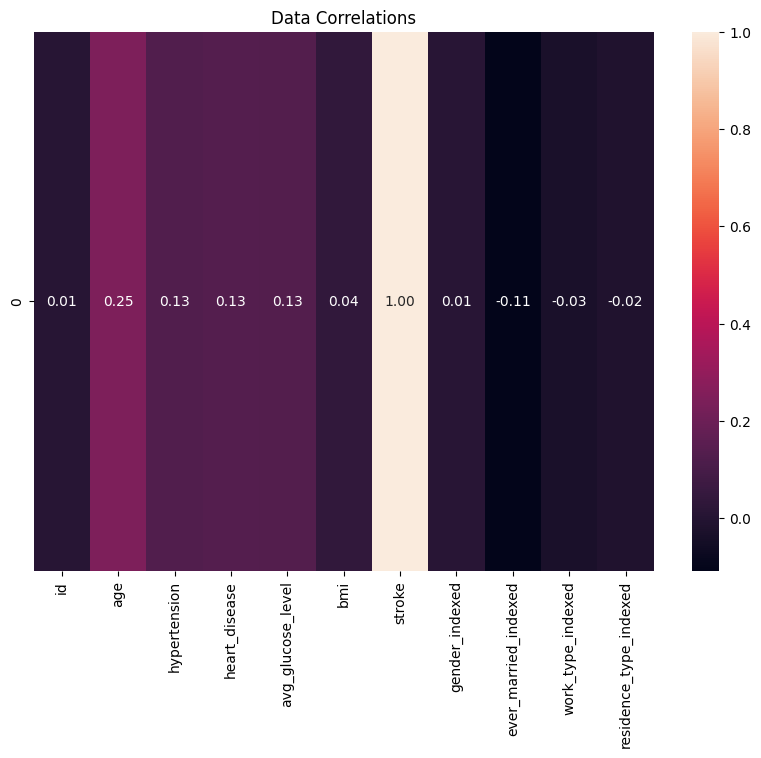

In [ ]:
# Plotting the heatmap of the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_df, annot=True, fmt='.2f', annot_kws={'size': 10})
plt.title("Data Correlations")
plt.show()

In [ ]:
# Selecting the numerical column and printing selected the numerical columns
numerical_cols = [col for col in df.columns if isinstance(df.select(col).schema[0].dataType, (IntegerType, DoubleType))]
print("Selected numerical columns:", numerical_cols)

Selected numerical columns: ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke', 'gender_indexed', 'ever_married_indexed', 'work_type_indexed', 'residence_type_indexed']


In [ ]:
# Creating a vectorassembler in oreder to combine into single vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')

In [ ]:
# Transforming the dataframe
df_transformed = assembler.transform(df).select('features')

In [ ]:
# Calculating the correclation for the features
correlation_matrix = Correlation.corr(df_transformed, 'features').collect()[0][0]
corr_values = correlation_matrix.toArray()

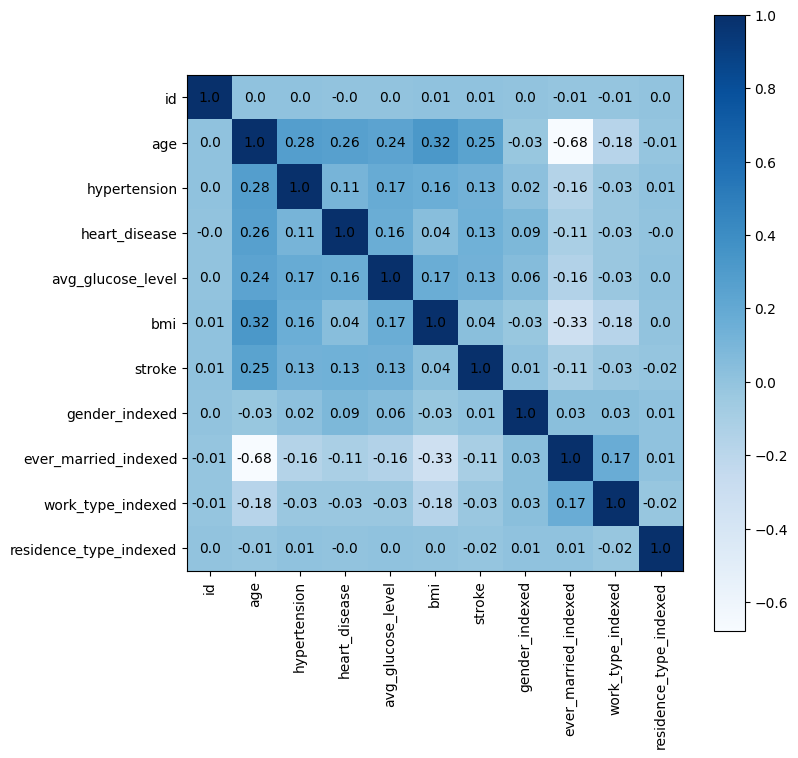

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `numerical_cols` and `corr_values` are already defined
plt.figure(figsize=(8, 8))
plt.imshow(corr_values, cmap='Blues', interpolation='nearest')

for i in range(len(numerical_cols)):
    for j in range(len(numerical_cols)):
        plt.text(j, i, np.round(corr_values[i, j], decimals=2), ha='center', va='center', color='black')

plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=90)
plt.yticks(range(len(numerical_cols)), numerical_cols)
plt.colorbar()
plt.show()


In [ ]:
import plotly.express as px
#Convert the Spark DataFrame to Pandas DataFrame
df_pandas = df.toPandas()

In [ ]:
# Map gender values to 1 (male) and 0 (female)
df_pandas['gender_indexed'] = df_pandas['gender_indexed'].map({1: 'Male', 0: 'Female'})

In [ ]:
# Create the box plot using Plotly Express
fig = px.box(df_pandas, x='stroke', y='age', color='gender_indexed', template='plotly_dark')

In [ ]:
fig.update_layout(
xaxis=dict(title='Stroke', tickfont=dict(size=12)),
yaxis=dict(title='Age of the people', tickfont=dict(size=12)),
legend=dict(font=dict(size=12)),
font_color='white'
)
fig.show()

In [ ]:
import plotly.express as px
#Convert the Spark DataFrame to Pandas DataFrame
df_pandas = df.toPandas()


In [ ]:
# Map gender values to 1 (male) and 0 (female)
df_pandas['gender_indexed'] = df_pandas['gender_indexed'].map({1: 'Male', 0: 'Female'})

In [ ]:
# Create the box plot using Plotly Express
fig = px.box(df_pandas, x='stroke', y='avg_glucose_level', color='gender_indexed', template='plotly_dark')

In [ ]:
fig.update_layout(
xaxis=dict(title='Stroke', tickfont=dict(size=12)),
yaxis=dict(title='avg_glucose_level', tickfont=dict(size=12)),
legend=dict(font=dict(size=12)),
                   font_color='white'
)
fig.show()

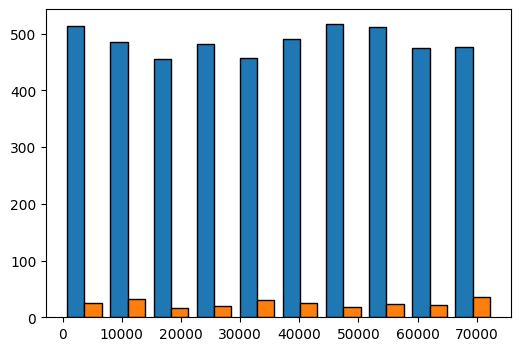

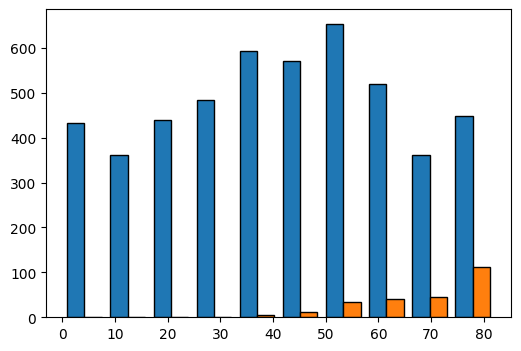

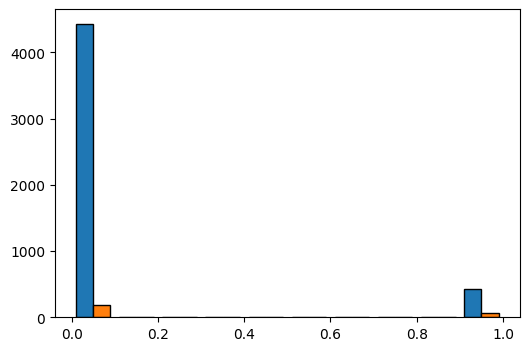

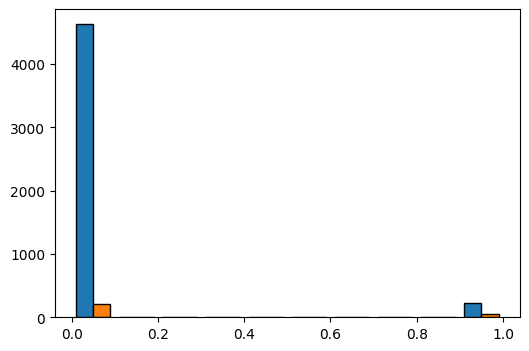

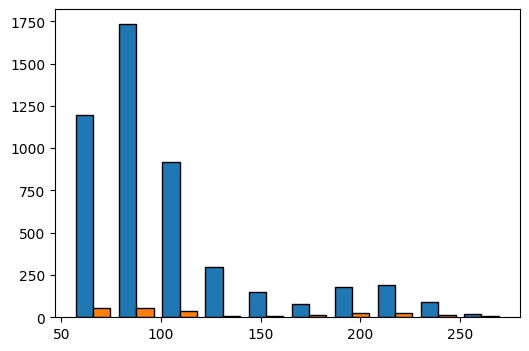

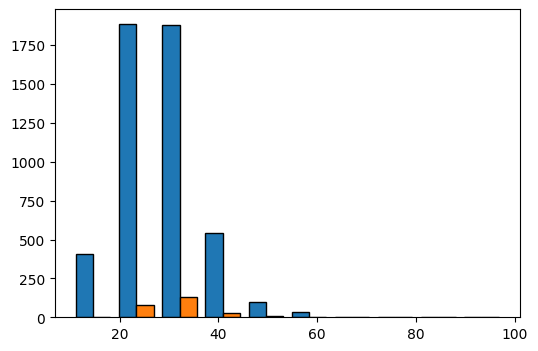

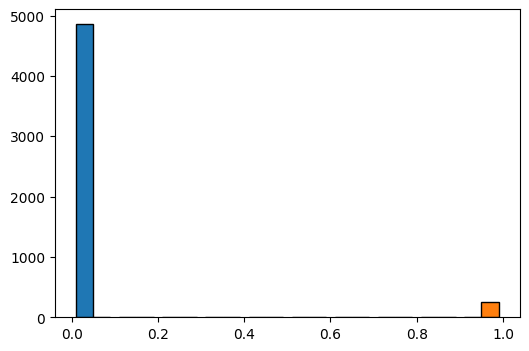

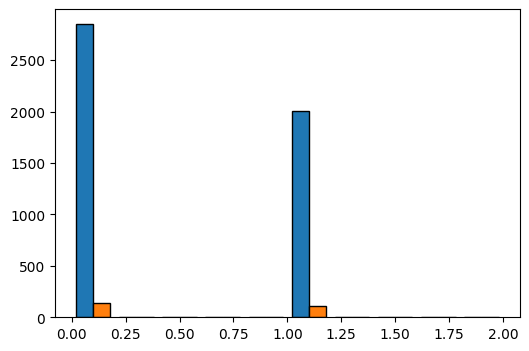

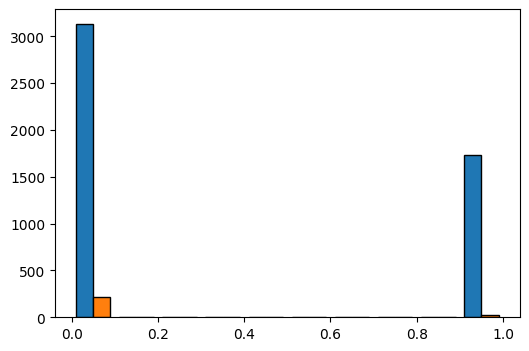

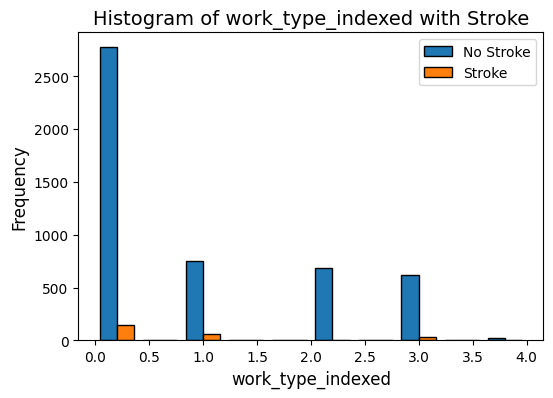

In [ ]:
for index, feature_name in enumerate(df.columns[:-1]):
      plt.figure(figsize=(6, 4)) # Adjust the figure size as needed
      plt.hist([df.filter(df["stroke"] == 0).select(feature_name).rdd.flatMap(lambda x: x).collect(),
          df.filter(df["stroke"] == 1).select(feature_name).rdd.flatMap(lambda x: x).collect()],
          label=["No Stroke", "Stroke"], bins=10, edgecolor='black')
plt.xlabel(feature_name, size=12)
plt.ylabel("Frequency", size=12)
plt.title(f"Histogram of {feature_name} with Stroke", size=14)
plt.legend()
plt.show()

**Outliers remove**

In [ ]:
# Removing outliers in 'avg_glucose_level' column for non-stroke cases
gluc = df.filter((col('avg_glucose_level') > 167) & (col('stroke') == 0)).select('id')

In [ ]:
# Creating a new dataframe without any kinds of outliers
test_df = df.join(gluc, df.id == gluc.id, "left_anti")

In [ ]:
# Updating the original dataframe with the new one without any kinds of outliers and displaying
df=test_df
df.show()


+-----+----+------------+-------------+-----------------+----+------+--------------+--------------------+-----------------+----------------------+
|   id| age|hypertension|heart_disease|avg_glucose_level| bmi|stroke|gender_indexed|ever_married_indexed|work_type_indexed|residence_type_indexed|
+-----+----+------------+-------------+-----------------+----+------+--------------+--------------------+-----------------+----------------------+
| 9046|67.0|           0|            1|           228.69|36.6|     1|           1.0|                 0.0|              0.0|                   0.0|
|51676|61.0|           0|            0|           202.21|27.9|     1|           0.0|                 0.0|              1.0|                   1.0|
|31112|80.0|           0|            1|           105.92|32.5|     1|           1.0|                 0.0|              0.0|                   1.0|
|60182|49.0|           0|            0|           171.23|34.4|     1|           0.0|                 0.0|             

**Vector Column Feature Created**

In [ ]:
# Defining the features columns which are assembled to be a vector
featureColumns=[
"gender_indexed",
"age",
"hypertension",
"heart_disease",
"ever_married_indexed",
"work_type_indexed",
"residence_type_indexed",
"avg_glucose_level",
"bmi",
]

In [ ]:
# Assemble the features into a vector column
assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")

In [ ]:
# Trnsforming the datafrae to include the assembled features
df_assembled = assembler.transform(df)

In [ ]:
# Displaying the dataframe with the assembled features
df_assembled.show()

+-----+----+------------+-------------+-----------------+----+------+--------------+--------------------+-----------------+----------------------+--------------------+
|   id| age|hypertension|heart_disease|avg_glucose_level| bmi|stroke|gender_indexed|ever_married_indexed|work_type_indexed|residence_type_indexed|            features|
+-----+----+------------+-------------+-----------------+----+------+--------------+--------------------+-----------------+----------------------+--------------------+
| 9046|67.0|           0|            1|           228.69|36.6|     1|           1.0|                 0.0|              0.0|                   0.0|[1.0,67.0,0.0,1.0...|
|51676|61.0|           0|            0|           202.21|27.9|     1|           0.0|                 0.0|              1.0|                   1.0|[0.0,61.0,0.0,0.0...|
|31112|80.0|           0|            1|           105.92|32.5|     1|           1.0|                 0.0|              0.0|                   1.0|[1.0,80.0,0.0,

**Train and Test split and Smote Resampling**

In [ ]:
train_df, test_df = df_assembled.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Convert train_df and test_df to Pandas DataFrames
train_pd = train_df.toPandas()

In [ ]:
# Select the features and labels for training
train_features = train_pd[["gender_indexed", "age","bmi", "hypertension", "heart_disease", "ever_married_indexed", "work_type_indexed", "residence_type_indexed"]]
train_labels = train_pd["stroke"]

In [ ]:
# Resampling the trainng the data using SMOTE
smote = SMOTE()
train_features_resampled, train_labels_resampled = smote.fit_resample(train_features, train_labels)

In [ ]:
# Creating a dataframe with resampled data
resampled_train_pd = pd.DataFrame(train_features_resampled, columns=train_features.columns)
resampled_train_pd["stroke"] = train_labels_resampled


In [ ]:
resampled_train_pd

,gender_indexed,age,bmi,hypertension,heart_disease,ever_married_indexed,work_type_indexed,residence_type_indexed,stroke
0,0.000000,17.000000,27.900000,0,0,1.0,0.000000,0.0,0
1,0.000000,13.000000,18.600000,0,0,1.0,2.000000,1.0,0
2,0.000000,42.000000,18.500000,0,0,1.0,0.000000,0.0,0
3,0.000000,31.000000,52.300000,0,0,1.0,0.000000,0.0,0
4,0.000000,38.000000,27.900000,0,0,0.0,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...
6967,0.348890,59.000000,27.900000,0,0,0.0,0.000000,1.0,1
6968,0.072066,68.072066,26.829718,0,0,0.0,0.927934,1.0,1
6969,0.000000,34.156408,32.764942,0,0,0.0,0.000000,1.0,1
6970,0.000000,76.000000,27.900000,0,0,0.0,0.307032,0.0,1


In [ ]:
# Preparing the data for training by creating the spaek dataframe from resampled pandas
train_df = spark.createDataFrame(resampled_train_pd)

In [ ]:
train_df.show()

+--------------+----+----+------------+-------------+--------------------+-----------------+----------------------+------+
|gender_indexed| age| bmi|hypertension|heart_disease|ever_married_indexed|work_type_indexed|residence_type_indexed|stroke|
+--------------+----+----+------------+-------------+--------------------+-----------------+----------------------+------+
|           0.0|17.0|27.9|           0|            0|                 1.0|              0.0|                   0.0|     0|
|           0.0|13.0|18.6|           0|            0|                 1.0|              2.0|                   1.0|     0|
|           0.0|42.0|18.5|           0|            0|                 1.0|              0.0|                   0.0|     0|
|           0.0|31.0|52.3|           0|            0|                 1.0|              0.0|                   0.0|     0|
|           0.0|38.0|27.9|           0|            0|                 0.0|              0.0|                   0.0|     0|
|           0.0|

In [ ]:
# Casting 'bmi' column to float type in the dataframe
df_numeric = train_df.withColumn("bmi", col("bmi").cast("float"))

In [ ]:
# Assemble the features into a vector column
assembler = VectorAssembler(inputCols=[
"gender_indexed",
"age",
"hypertension",
"heart_disease",
"ever_married_indexed",
"work_type_indexed",
"residence_type_indexed",
"avg_glucose_level",
"bmi",
], outputCol="features")


In [ ]:
df_assembled.show()

+-----+----+------------+-------------+-----------------+----+------+--------------+--------------------+-----------------+----------------------+--------------------+
|   id| age|hypertension|heart_disease|avg_glucose_level| bmi|stroke|gender_indexed|ever_married_indexed|work_type_indexed|residence_type_indexed|            features|
+-----+----+------------+-------------+-----------------+----+------+--------------+--------------------+-----------------+----------------------+--------------------+
| 9046|67.0|           0|            1|           228.69|36.6|     1|           1.0|                 0.0|              0.0|                   0.0|[1.0,67.0,0.0,1.0...|
|51676|61.0|           0|            0|           202.21|27.9|     1|           0.0|                 0.0|              1.0|                   1.0|[0.0,61.0,0.0,0.0...|
|31112|80.0|           0|            1|           105.92|32.5|     1|           1.0|                 0.0|              0.0|                   1.0|[1.0,80.0,0.0,

**Logistic Regression, Model Evaluation and Prediction**

In [ ]:
# Create a LogisticRegression instance
lr = LogisticRegression(labelCol="stroke", featuresCol="features")

In [ ]:
# Fit the model on the training data
lrModel = lr.fit(df_assembled)

In [ ]:
trainingSummary=lrModel.summary
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall

In [ ]:
print("Accuracy Data:")
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
% (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy Data:
Accuracy: 0.9609563500767713
FPR: 0.6417593765678865
TPR: 0.9609563500767713
F-measure: 0.952071000299793
Precision: 0.9587342491163278
Recall: 0.9609563500767713


In [ ]:
# Make predictions on the assembled DataFrame
predictions = lrModel.transform(df_assembled)

In [ ]:
# Select example rows to display.
predictions.select("prediction", "stroke", "features").show()

+----------+------+--------------------+
|prediction|stroke|            features|
+----------+------+--------------------+
|       1.0|     1|[1.0,67.0,0.0,1.0...|
|       1.0|     1|[0.0,61.0,0.0,0.0...|
|       0.0|     1|[1.0,80.0,0.0,1.0...|
|       0.0|     1|(9,[1,7,8],[49.0,...|
|       1.0|     1|[0.0,79.0,1.0,0.0...|
|       1.0|     1|(9,[0,1,7,8],[1.0...|
|       0.0|     1|[1.0,74.0,1.0,1.0...|
|       0.0|     1|(9,[1,4,7,8],[69....|
|       0.0|     1|(9,[1,6,7,8],[59....|
|       0.0|     1|(9,[1,7,8],[78.0,...|
|       0.0|     1|[0.0,81.0,1.0,0.0...|
|       0.0|     1|[0.0,61.0,0.0,1.0...|
|       0.0|     1|(9,[1,7,8],[54.0,...|
|       1.0|     1|[1.0,78.0,0.0,1.0...|
|       1.0|     1|(9,[1,3,7,8],[79....|
|       0.0|     1|[0.0,50.0,1.0,0.0...|
|       1.0|     1|[1.0,64.0,0.0,1.0...|
|       1.0|     1|[1.0,75.0,1.0,0.0...|
|       0.0|     1|(9,[1,4,7,8],[60....|
|       1.0|     1|[1.0,57.0,0.0,1.0...|
+----------+------+--------------------+
only showing top

In [ ]:
# Binary Classification Metrics
binary_evaluator = BinaryClassificationEvaluator(labelCol="stroke")
auc_roc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
auc_pr = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderPR"})

In [ ]:
# Print the metrics
print("Binary Classification Metrics:")
print("AUC-ROC:", auc_roc)
print("AUC-PR:", auc_pr)

Binary Classification Metrics:
AUC-ROC: 0.8875152582487682
AUC-PR: 0.5300615361604687


In [ ]:
# Make predictions on the test data
test_predictions = lrModel.transform(test_df)

In [ ]:
# Set the threshold for prediction
threshold = 0.5

In [ ]:
# Map predicted values to 0 and 1 based on the threshold
test_predictions = test_predictions.withColumn("prediction_mapped", (test_predictions.prediction >= threshold).cast("double"))

In [ ]:
# Select relevant columns to display
test_predictions.select("prediction_mapped", "stroke", "features").show()

+-----------------+------+--------------------+
|prediction_mapped|stroke|            features|
+-----------------+------+--------------------+
|              0.0|     0|(9,[0,1,7,8],[1.0...|
|              0.0|     0|(9,[1,4,7,8],[24....|
|              0.0|     0|(9,[1,6,7,8],[33....|
|              0.0|     0|(9,[1,6,7,8],[43....|
|              0.0|     0|[1.0,45.0,0.0,0.0...|
|              0.0|     0|(9,[1,7,8],[65.0,...|
|              0.0|     0|(9,[1,5,7,8],[37....|
|              0.0|     0|[0.0,3.0,0.0,0.0,...|
|              0.0|     0|[0.0,52.0,1.0,0.0...|
|              0.0|     0|[1.0,17.0,0.0,0.0...|
|              0.0|     0|[1.0,44.0,0.0,0.0...|
|              0.0|     0|[1.0,10.0,0.0,0.0...|
|              0.0|     0|[0.0,39.0,0.0,0.0...|
|              0.0|     0|(9,[1,4,7,8],[32....|
|              0.0|     0|(9,[1,4,7,8],[14....|
|              0.0|     0|[0.0,70.0,1.0,0.0...|
|              0.0|     0|[0.0,43.0,0.0,0.0...|
|              0.0|     0|(9,[1,6,7,8],[

**Model Evaluation Metrics**

In [ ]:
# Create a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="stroke")

In [ ]:
# Evaluate the model using the mapped predictions
areaUnderROC = evaluator.evaluate(test_predictions, {evaluator.metricName: "areaUnderROC"})
areaUnderPR = evaluator.evaluate(test_predictions, {evaluator.metricName: "areaUnderPR"})

In [ ]:
# Print the evaluation results
print("Area Under ROC:", areaUnderROC)
print("Area Under PR:", areaUnderPR)

Area Under ROC: 0.8486561686005348
Area Under PR: 0.48232757150734207


In [ ]:
# Calculate evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction")

In [ ]:
accuracy = evaluator.evaluate(test_predictions, {evaluator.metricName: "accuracy"})
weightedFalsePositiveRate = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedFalsePositiveRate"})
weightedTruePositiveRate = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedTruePositiveRate"})
weightedFMeasure = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedFMeasure"})
weightedPrecision = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedPrecision"})
weightedRecall = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedRecall"})

In [ ]:
print("Accuracy: %s" % accuracy)
print("Weighted False Positive Rate: %s" % weightedFalsePositiveRate)
print("Weighted True Positive Rate: %s" % weightedTruePositiveRate)
print("Weighted F-measure: %s" % weightedFMeasure)
print("Weighted Precision: %s" % weightedPrecision)
print("Weighted Recall: %s" % weightedRecall)

Accuracy: 0.9641618497109826
Weighted False Positive Rate: 0.6507294556783045
Weighted True Positive Rate: 0.9641618497109827
Weighted F-measure: 0.9565703748330121
Weighted Precision: 0.9596959530763837
Weighted Recall: 0.9641618497109827


**Training SVM Model**

In [ ]:
# Define the SVM model
svm = LinearSVC(featuresCol='features', labelCol='stroke')
# Create a pipeline for SVM model
svm_pipeline = Pipeline(stages=[svm])
# Fitting the model for training data
svm_model = svm_pipeline.fit(df_assembled)

**Random Forest Model**

In [ ]:
# Define the Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='stroke')
# Create a pipeline for Random Forest Model
rf_pipeline = Pipeline(stages=[rf])
# Fitting the model for training data
rf_model = rf_pipeline.fit(df_assembled)

**Traning Decision Model**

In [ ]:
# Define the Decision Tree model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='stroke')
# Create a pipeline for Decission Tree model
dt_pipeline = Pipeline(stages=[dt])
# Fitting the model for training data
dt_model = dt_pipeline.fit(df_assembled)

**Evaluation and Predictions of the model**

In [ ]:
multiclass_evaluator = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="stroke")  # Specify metric

In [ ]:
svm_predictions = svm_model.transform(df_assembled)

In [ ]:
regression_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="stroke", metricName="rmse")

In [ ]:
# SVM
svm_predictions = svm_model.transform(df_assembled)
svm_accuracy = multiclass_evaluator.evaluate(svm_predictions)
svm_rmse = regression_evaluator.evaluate(svm_predictions)
svm_fpr = svm_predictions.filter("stroke = 0 and prediction = 1").count() / svm_predictions.filter("stroke = 0").count()
svm_tpr = svm_predictions.filter("stroke = 1 and prediction = 1").count() / svm_predictions.filter("stroke = 1").count()

In [ ]:
print("SVM Accuracy:", svm_accuracy)
print("SVM RMSE:", svm_rmse)
print("SVM FPR:", svm_fpr)
print("SVM TPR:", svm_tpr)

SVM Accuracy: 0.9611756964246545
SVM RMSE: 0.19703883773344144
SVM FPR: 0.0004640371229698376
SVM TPR: 0.2971887550200803


In [ ]:
# Random Forest
rf_predictions = rf_model.transform(df_assembled)
rf_accuracy = multiclass_evaluator.evaluate(rf_predictions)
rf_rmse = regression_evaluator.evaluate(rf_predictions)
rf_fpr = rf_predictions.filter("stroke = 0 and prediction = 1").count() / rf_predictions.filter("stroke = 0").count()
rf_tpr = rf_predictions.filter("stroke = 1 and prediction = 1").count() / rf_predictions.filter("stroke = 1").count()

In [ ]:
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest RMSE:", rf_rmse)
print("Random Forest FPR:", rf_fpr)
print("Random Forest TPR:", rf_tpr)

Random Forest Accuracy: 0.9624917745119543
Random Forest RMSE: 0.19367040426468268
Random Forest FPR: 0.0018561484918793504
Random Forest TPR: 0.3453815261044177


In [ ]:
dt_predictions = dt_model.transform(df_assembled)
dt_accuracy = multiclass_evaluator.evaluate(dt_predictions)
dt_rmse = regression_evaluator.evaluate(dt_predictions)
dt_fpr = dt_predictions.filter("stroke = 0 and prediction = 1").count() / dt_predictions.filter("stroke = 0").count()
dt_tpr = dt_predictions.filter("stroke = 1 and prediction = 1").count() / dt_predictions.filter("stroke = 1").count()

In [ ]:
print("Decision Tree Accuracy:", dt_accuracy)
print("Decision Tree RMSE:", dt_rmse)
print("Decision Tree FPR:", dt_fpr)
print("Decision Tree TPR:", dt_tpr)

Decision Tree Accuracy: 0.9644658916429042
Decision Tree RMSE: 0.1885049292647167
Decision Tree FPR: 0.0020881670533642693
Decision Tree TPR: 0.3855421686746988


In [ ]:
# Make predictions on the training data
svm_predictions = svm_model.transform(test_df)
rf_predictions = rf_model.transform(test_df)
dt_predictions = dt_model.transform(test_df)

In [ ]:
# Define the evaluation metrics
multiclass_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='stroke', metricName='accuracy')
regression_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='stroke', metricName='rmse')

In [ ]:
# Calculate the evaluation metrics for each model
svm_accuracy = multiclass_evaluator.evaluate(svm_predictions)
rf_accuracy = multiclass_evaluator.evaluate(rf_predictions)
dt_accuracy = multiclass_evaluator.evaluate(dt_predictions)

In [ ]:
svm_rmse = regression_evaluator.evaluate(svm_predictions)
rf_rmse = regression_evaluator.evaluate(rf_predictions)
dt_rmse = regression_evaluator.evaluate(dt_predictions)

In [ ]:
# Calculate FPR and TPR
svm_fpr = svm_predictions.filter("stroke = 0 and prediction = 1").count() / svm_predictions.filter("stroke = 0").count()
svm_tpr = svm_predictions.filter("stroke = 1 and prediction = 1").count() / svm_predictions.filter("stroke = 1").count()
rf_fpr = rf_predictions.filter("stroke = 0 and prediction = 1").count() / rf_predictions.filter("stroke = 0").count()
rf_tpr = rf_predictions.filter("stroke = 1 and prediction = 1").count() / rf_predictions.filter("stroke = 1").count()
dt_fpr = dt_predictions.filter("stroke = 0 and prediction = 1").count() / dt_predictions.filter("stroke = 0").count()
dt_tpr = dt_predictions.filter("stroke = 1 and prediction = 1").count() / dt_predictions.filter("stroke = 1").count()

In [ ]:
# Print the evaluation metrics
print("SVM Accuracy:", svm_accuracy)
print("SVM RMSE:", svm_rmse)
print("SVM FPR:", svm_fpr)
print("SVM TPR:", svm_tpr)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest RMSE:", rf_rmse)
print("Random Forest FPR:", rf_fpr)
print("Random Forest TPR:", rf_tpr)
print("Decision Tree Accuracy:", dt_accuracy)
print("Decision Tree RMSE:", dt_rmse)
print("Decision Tree FPR:", dt_fpr)
print("Decision Tree TPR:", dt_tpr)

SVM Accuracy: 0.9653179190751445
SVM RMSE: 0.18623125657326026
SVM FPR: 0.0
SVM TPR: 0.2682926829268293
Random Forest Accuracy: 0.9653179190751445
Random Forest RMSE: 0.18623125657326026
Random Forest FPR: 0.0012135922330097086
Random Forest TPR: 0.2926829268292683
Decision Tree Accuracy: 0.9664739884393063
Decision Tree RMSE: 0.18310109655786783
Decision Tree FPR: 0.0012135922330097086
Decision Tree TPR: 0.3170731707317073


**Comparing each model**

In [ ]:
import matplotlib.pyplot as plt
#Define the evaluation metric values for each model
accuracy_values = [accuracy, svm_accuracy, rf_accuracy, dt_accuracy]
rmse_values = [0, svm_rmse, rf_rmse, dt_rmse]
fpr_values = [weightedFalsePositiveRate, svm_fpr, rf_fpr, dt_fpr]
tpr_values = [weightedTruePositiveRate, svm_tpr, rf_tpr, dt_tpr]

In [ ]:
# Define the model names
model_names = ['Logistic Regression', 'SVM', 'Random Forest', 'Decision Tree']

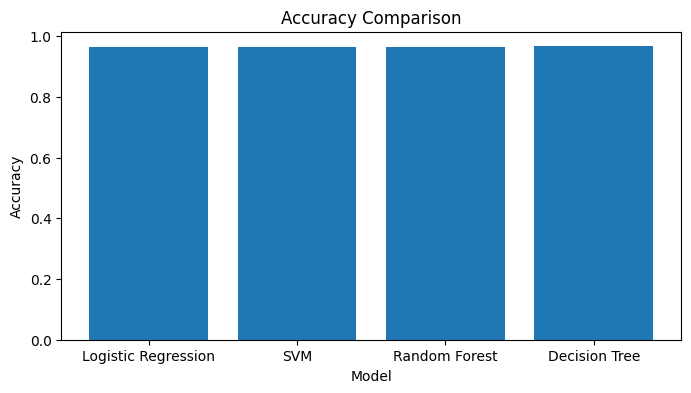

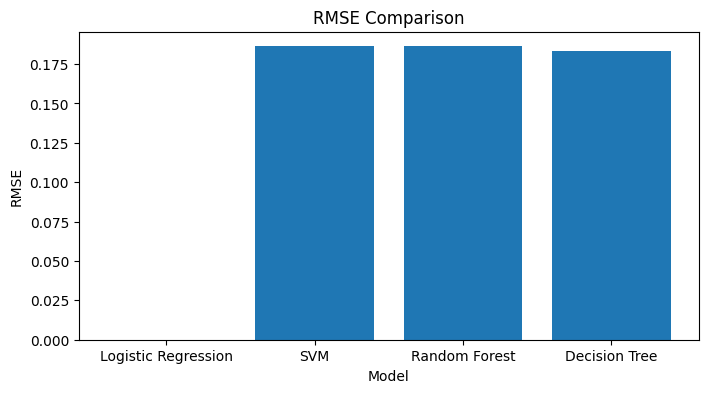

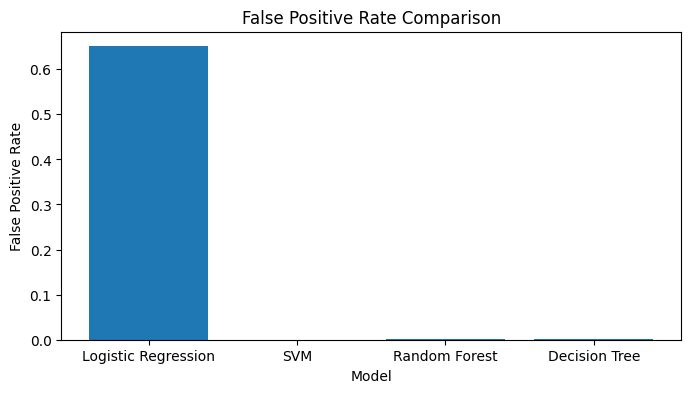

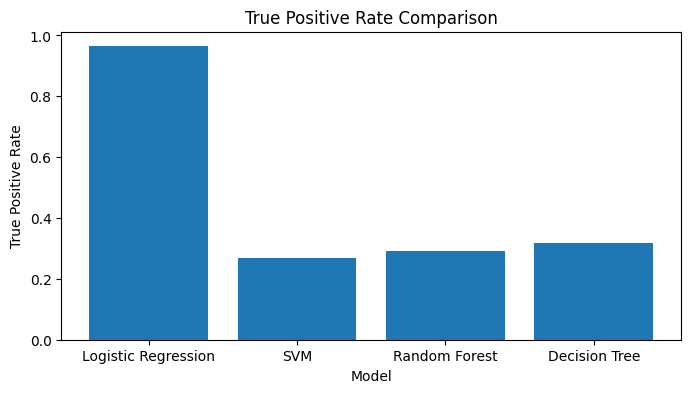

In [ ]:
# Plot the accuracy comparison
plt.figure(figsize=(8, 4))
plt.bar(model_names, accuracy_values)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()
# Plot the RMSE comparison
plt.figure(figsize=(8, 4))
plt.bar(model_names, rmse_values)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.show()
# Plot the FPR comparison
plt.figure(figsize=(8, 4))
plt.bar(model_names, fpr_values)
plt.xlabel('Model')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate Comparison')
plt.show()
# Plot the TPR comparison
plt.figure(figsize=(8, 4))
plt.bar(model_names, tpr_values)
plt.xlabel('Model')
plt.ylabel('True Positive Rate')
plt.title('True Positive Rate Comparison')
plt.show()